In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
#from matplotlib.patches import Rectangle

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/kaggle"

%cd /content/drive/My Drive/kaggle 

/content/drive/My Drive/kaggle


In [ ]:
!kaggle datasets download -d crawford/emnist

emnist.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip \*.zip && rm *.zip

Archive:  emnist.zip
replace emnist-balanced-mapping.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: emnist-balanced-mapping.txt  
replace emnist-balanced-test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: emnist-balanced-test.csv  
  inflating: emnist-balanced-train.csv  
  inflating: emnist-byclass-mapping.txt  
  inflating: emnist-byclass-test.csv  
  inflating: emnist-byclass-train.csv  
  inflating: emnist-bymerge-mapping.txt  
  inflating: emnist-bymerge-test.csv  
  inflating: emnist-bymerge-train.csv  
  inflating: emnist-digits-mapping.txt  
  inflating: emnist-digits-test.csv  
  inflating: emnist-digits-train.csv  
  inflating: emnist-letters-mapping.txt  
  inflating: emnist-letters-test.csv  
  inflating: emnist-letters-train.csv  
  inflating: emnist-mnist-mapping.txt  
  inflating: emnist-mnist-test.csv   
  inflating: emnist-mnist-train.csv  
  inflating: emnist_source_files/emnist-balanced-test-images-idx3-ubyte  
  inflating: emnist_source_files/

In [ ]:
train = pd.read_csv("/content/drive/My Drive/kaggle/emnist-letters-train.csv", delimiter=",") 
test =  pd.read_csv("/content/drive/My Drive/kaggle/emnist-letters-test.csv", delimiter=",")

In [ ]:
#from sklearn.model_selection import train_test_split
#train and test split
x_train = train.iloc[:, 1:]
y_train = train.iloc[:, 0] 

x_test = test.iloc[:, 1:]
y_test = test.iloc[:, 0]
#x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size= 0.10, random_state=7)

print('Training set:',x_train.shape,' ',y_train.shape)
print('Testing set: ',x_test.shape,' ',y_test.shape)

Training set: (88799, 784)   (88799,)
Testing set:  (14799, 784)   (14799,)


In [ ]:
#Reshaping from 2-dim to 3-dim
def rotate(a):
  a = a.reshape([28,28])
  a = np.fliplr(a)
  a = np.rot90(a)
  return a

x_train = np.asarray(x_train)
x_train = np.apply_along_axis(rotate, 1, x_train)
x_test = np.asarray(x_test)
x_test = np.apply_along_axis(rotate, 1, x_test)

print("Train set: ",x_train.shape,' ','Test set: ',x_test.shape)

Train set:  (88799, 28, 28)   Test set:  (14799, 28, 28)


In [ ]:
#Reshaping images from 3-dim to 4-dim
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)
input_shape = (28, 28, 1)

In [ ]:
#Normalizing the data
x_train = x_train.astype('float32') 
x_train /= 255

x_test = x_test.astype('float32') 
x_test /= 255

print('Training set:',x_train.shape)
print('Testing set: ',x_test.shape)

Training set: (88799, 28, 28, 1)
Testing set:  (14799, 28, 28, 1)


In [ ]:
#One hot encoding
from keras.utils.np_utils import to_categorical

for i in range(y_train.shape[0]):
  y_train.iloc[i,] -=1
for i in range(y_test.shape[0]):
  y_test.iloc[i,] -=1

nclasses =y_train.nunique()
print("No of classes: ",nclasses)
y_train = to_categorical(y_train, nclasses)
y_test = to_categorical(y_test, nclasses)

print(y_test[0])

print("y_train: ",y_train.shape,' ',"y_test: ",y_test.shape)

No of classes:  26
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
y_train:  (88799, 26)   y_test:  (14799, 26)


In [ ]:
#Net definition
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

net = Sequential()

net.add(Conv2D(filters = 32, kernel_size = (5,5), activation = 'relu', input_shape = (28,28,1)))
net.add(Conv2D(filters = 32, kernel_size = (5,5), activation = 'relu'))
net.add(MaxPooling2D(pool_size = (2,2)))

net.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
net.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
net.add(MaxPooling2D(pool_size = (2,2)))

net.add(Flatten())
net.add(Dense(256, activation = 'relu'))
net.add(Dense(nclasses, activation = 'softmax'))
net.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0

In [ ]:
#compile the net
net.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
#fit the net
history = net.fit(x_train, y_train, epochs=15, batch_size=128, verbose=1, validation_data=(x_test, y_test))

Epoch 1/15
694/694 [==============================] - 227s 327ms/step - loss: 0.1730 - accuracy: 0.9399 - val_loss: 0.2297 - val_accuracy: 0.9236
Epoch 2/15
694/694 [==============================] - 226s 326ms/step - loss: 0.1544 - accuracy: 0.9443 - val_loss: 0.2286 - val_accuracy: 0.9220
Epoch 3/15
694/694 [==============================] - 226s 326ms/step - loss: 0.1394 - accuracy: 0.9493 - val_loss: 0.2201 - val_accuracy: 0.9253
Epoch 4/15
694/694 [==============================] - 227s 327ms/step - loss: 0.1260 - accuracy: 0.9520 - val_loss: 0.2198 - val_accuracy: 0.9292
Epoch 5/15
694/694 [==============================] - 226s 326ms/step - loss: 0.1168 - accuracy: 0.9557 - val_loss: 0.2110 - val_accuracy: 0.9278
Epoch 6/15
694/694 [==============================] - 226s 326ms/step - loss: 0.1065 - accuracy: 0.9588 - val_loss: 0.2185 - val_accuracy: 0.9260
Epoch 7/15
694/694 [==============================] - 226s 325ms/step - loss: 0.0991 - accuracy: 0.9613 - val_loss: 0.2317 -

In [ ]:
#Test Loss and Accuracy
score = net.evaluate(x_test, y_test, verbose=0)
print("loss: {0:5f}".format(score[0]))
print("accuracy: {0:5f}".format(score[1]))
net.save('hw_trained_net.h5')

loss: 0.293779
accuracy: 0.926279


In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/kaggle/hw_trained_net.h5')

In [ ]:
# testing phase

test_img = x_test[0,:]
print(test_img.shape)

ypred = model.predict(test_img)
print(ypred)

ls = "ABCDEFGHIHKLMNOPQRSTUVWXYZ"
labels = [l for l in ls]

i= np.argmax(ypred)
c = labels[i]
print(c)

(1, 28, 28, 1)
[[0.03517398 0.04110366 0.04573852 0.03207786 0.06548755 0.04408204
  0.05842637 0.02447805 0.03852747 0.05296411 0.02251134 0.04703412
  0.01799492 0.01624633 0.04252363 0.04982241 0.05245662 0.01684896
  0.05085253 0.02964586 0.02757128 0.02605547 0.03887031 0.02501253
  0.04126688 0.05722721]]
E


In [ ]:
def sort_contours(cnts, method="left-to-right"):
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes), key=lambda b:b[1][i], reverse=False))
    
    return (cnts, boundingBoxes)

In [ ]:
import imutils

def get_letters(img):

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    kernel = np.ones((5,5), np.uint8)
    ret,thresh1 = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    plt.imshow(thresh1)
    plt.title("thresholded image")
    plt.show()

    dilated = cv2.dilate(thresh1, kernel, iterations=2)
    plt.imshow(dilated)
    plt.title("dilated image")
    plt.show()
    
    
    cnts = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    cnts = sort_contours(cnts, method="left-to-right")[0]

    
    letters = []

    for c in cnts:
      if cv2.contourArea(c) > 10: 
        (x, y, w, h) = cv2.boundingRect(c)

        if (w >= 15 and w <= 150) and (h >= 20 and h <= 180):         
          cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
          roi = gray[y:y + h, x:x + w]
          thresh = cv2.threshold(roi, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        
          thresh = cv2.resize(thresh, (28, 28), interpolation = cv2.INTER_CUBIC)
          thresh = thresh.astype("float32") / 255.0
          thresh = np.expand_dims(thresh, axis=-1)
          thresh = thresh.reshape(-1,28,28,1)
      
          ypred = model.predict(thresh)
          [x] = ypred
          letters.append(x)
    
    return letters, img

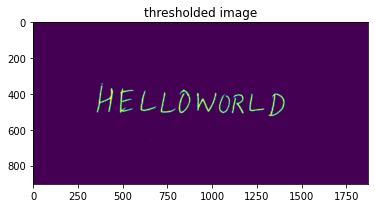

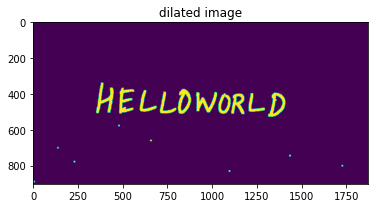

10


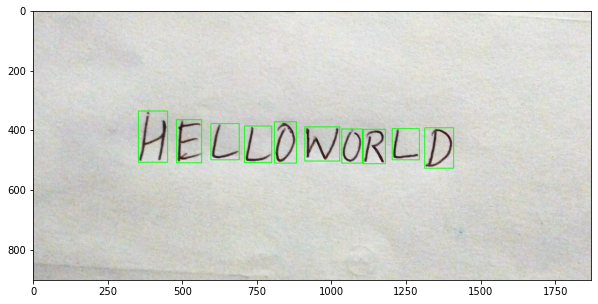

In [ ]:
inp_img = cv2.imread('/content/drive/MyDrive/img3.0.jpg')
letter, im1 = get_letters(inp_img) 
print(len(letter))

plt.figure(figsize=(10,10))
plt.imshow(im1)
plt.show()

In [ ]:
ls = "ABCDEFGHIHKLMNOPQRSTUVWXYZ"
labels = [l for l in ls]

for ypred in letter:
  i= np.argmax(ypred)
  c = labels[i]
  print(c, end="")

HELLOMORLD